# Evaluate the AUC-SMA feature

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3

db = sqlite3.connect('/Users/jluan/code/finance/data/fmp_data.db')
def query(sql):
  df = pd.read_sql_query(sql, db)
  return df

%matplotlib inline
%load_ext autoreload
%autoreload 2

from statistics import mean, median
from random_ideas import hold_days_after_buy
from feature_gen.auc_sma import AUC_SMA






The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# A brief look at how do the AUC-SMA featurey perform

In [29]:
from feature_gen.auc_sma import AUC_SMA

stocks = ['AAPL', 'MSFT', 'GOOG', 'AMZN', 'META', 'TSM', 'CCL', 'MSCI', 'CLS', 'NVDA',
          'ABNB', 'BRK-A', 'ZETA', 'AGX', 'TWLO', 'TMUS', 'SKYW', 'GM', 'CRS', 'PFG', 'SNAP', 'LYFT']

sorted([(symbol,
         round((100 * AUC_SMA(symbol=symbol, current_date='2024-11-01', look_back_days=300, slow_days=90, fast_days=30).calculate()), 2)) for symbol in
        stocks], key=lambda x: x[1], reverse=True)

[('ZETA', 14.67),
 ('CRS', 11.55),
 ('NVDA', 10.8),
 ('CLS', 10.0),
 ('AGX', 9.45),
 ('SKYW', 7.29),
 ('META', 6.24),
 ('TSM', 6.19),
 ('TMUS', 4.11),
 ('AMZN', 3.46),
 ('GOOG', 2.82),
 ('BRK-A', 2.78),
 ('GM', 2.68),
 ('MSFT', 2.4),
 ('AAPL', 2.14),
 ('MSCI', 1.48),
 ('PFG', 1.28),
 ('LYFT', 1.14),
 ('CCL', 1.03),
 ('TWLO', -0.04),
 ('ABNB', -0.33),
 ('SNAP', -0.64)]

# Correlation with future price gain

2023-01 to 2024-01

In [139]:
start = '2023-01-05'
end = '2023-03-03'

p = query(f"""
select S.symbol, end_price / start_price - 1 as gain
from stock22to24 S
join (
    select symbol, adjusted_close as start_price
    from daily_price
    where date = '{start}'
) AS A
join (
    select symbol, adjusted_close as end_price
    from daily_price
    where date = '{end}'
) AS B
ON S.symbol = A.symbol AND S.symbol = B.symbol
""")

idx = query(f'''
select A.symbol, end_price / start_price - 1 as gain
from (
    select symbol, adjusted_close as start_price
    from daily_price
    where date = '{start}' and symbol  in ('^SPX', 'QQQ', '^DJI')
) AS A
join (
    select symbol, adjusted_close as end_price
    from daily_price
    where date = '{end}' and symbol in ('^SPX', 'QQQ', '^DJI')
) AS B
ON B.symbol = A.symbol
''')
p = pd.concat([p, idx], axis=0)
p = p.set_index('symbol')
spx = p.loc['^SPX'].gain

sample = np.random.choice(p.index.values, 1000, replace=False)

In [141]:
p

,gain
symbol,
GOOS,0.024274
RL,0.038723
TECK,0.126676
RVTY,-0.053352
UBER,0.353033
...,...
AL-PA,0.021566
SGH,0.177486
QQQ,0.145630


In [142]:
f = pd.DataFrame.from_dict({sym: AUC_SMA(symbol=sym,
                                         current_date='2023-01-04',
                                         look_back_days=300,
                                         slow_days=90,
                                         fast_days=30).value for sym in sample}, orient='index', columns=['momentum'])

In [151]:
df = f.join(p, how='left')
df = df[(df.gain.abs() < 1) & (df.momentum > -0.11)]
df.head()

,momentum,gain
ALC,-0.020833,-0.025122
EBAY,-0.053121,0.068226
ALSN,0.011470,0.172006
LUV,-0.033073,0.024337
ESS,-0.030568,0.127759


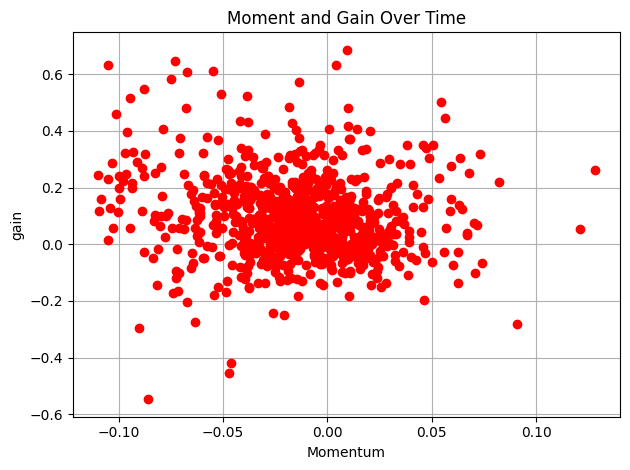

In [152]:

plt.plot(df['momentum'], df['gain'], 'o',label='Gain', color='red')

plt.xlabel('Momentum')
plt.ylabel('gain')
plt.title('Moment and Gain Over Time')
plt.grid(True)
plt.tight_layout()
plt.show()
